In [1]:
import pickle
import numpy as np
import pandas as pd
import scipy.sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob as tb
#from cltk.tokenize.sentence import TokenizeSentence
import re
from cltk.stop.classical_hindi.stops import STOPS_LIST
import json
from sklearn.linear_model import LogisticRegression

In [2]:
def generate_dataset(filepath):
    premise = []
    hypothesis = []
    label = []
    with open(filepath, "r") as f:
        data = json.load(f)
        data = data[list(data.keys())[0]]
        #print(data)
    for idx, row in enumerate(data):
        premise.append(row["premise"])
        hypothesis.append(row["hypothesis"])
        label.append(row["label"])
    df = pd.DataFrame(list(zip(premise, hypothesis,label)),
               columns =['premise', 'hypothesis','label'])
    return df

In [3]:
def TFIDF_features(data,mode):
    # Get the sentences and labels from composite data
    list_sentence1 = data['premise']
    list_sentence2 = data['hypothesis']
    list_gold_label = data['label']
    # Merge each sublist (tokens list of each sentence) to a string
    corpus_sentence1 = [''.join(item) for item in list_sentence1]
    corpus_sentence2 = [''.join(item) for item in list_sentence2]
    num_samples = len(list_gold_label)
    # Create a composite corpus over which to train the TFIDF Vectorizer
    # Corresponding lines of sentence1 and sentence2 are merged together
    corpus = [corpus_sentence1[ind] + " " + corpus_sentence2[ind] for ind in range(num_samples)]
    tfidf_labels = list_gold_label
    
    if mode == "train":
        TFIDF_vect = TfidfVectorizer()
        TFIDF_vect.fit(corpus)

        with open('model/TFIDF.pickle', "wb") as file:
            pickle.dump(TFIDF_vect, file)

    elif mode == "test":
        with open('model/TFIDF.pickle', "rb") as file:
            TFIDF_vect = pickle.load(file)

    else:
        print("Invalid mode selection")
        exit(0)
    # Generate TFIDF representations for out dataset
    tfidf_sentecnce1 = TFIDF_vect.transform(corpus_sentence1)
    tfidf_sentecnce2 = TFIDF_vect.transform(corpus_sentence2)
    tfidf_feature_array = scipy.sparse.hstack((tfidf_sentecnce1, tfidf_sentecnce2))

    return tfidf_feature_array, tfidf_labels

In [4]:
def logistic_regression_train(train_data):
    # Obtain the TFIDF features
    train_feature, train_label = TFIDF_features(train_data, "train")

    # Train the logistic regression model
    LR_model = LogisticRegression(random_state=0, max_iter=1000, solver='lbfgs', multi_class='auto')
    LR_model.fit(train_feature, train_label)
    
    # Save the logistic regression model as a pickle file
    with open('model/LR.pickle', "wb") as file:
        pickle.dump(LR_model, file)

    print("Training complete.\n")


In [35]:
# Loads and tests the logistic regression model
test_label_original = []
predicted_label = []
def logistic_regression_test(test_data):
    # Obtain the TFIDF features
    test_feature, test_label = TFIDF_features(test_data, "test")
    #print("Demo original label: ",test_label[0])
    test_label_original.append(test_label)
    # Loads the logistic regression model from pickle file
    with open('model/LR.pickle', "rb") as file:
        LR_model = pickle.load(file)

    # Tests the logistic regression model
    pred_labels = LR_model.predict(test_feature)
    predicted_label.append(pred_labels)
    #print("Demo predicted label: ",pred_labels)
    if pred_labels == 0:
        label = "entailments"
    elif pred_labels == 1:
        label = "neutral\n"
    elif pred_labels == 2:
        label = "contradiction\n"
    

    # Evaluate and print the results
    score = LR_model.score(test_feature, test_label) * 100 
    #print("The classification accuracy for Logistic regression with TF-IDF features is {:.2f}%.".format(score))
    print(label)

In [6]:
train_data = generate_dataset('xnli_hi_train.json')
test_data = generate_dataset('xnli_hi_test.json')

In [7]:
logistic_regression_train(train_data)

Training complete.



In [8]:
logistic_regression_test(test_data)

Demo original label:  2
Demo predicted label:  [2 1 1 ... 1 1 1]
The classification accuracy for Logistic regression with TF-IDF features is 49.94%.


In [9]:
from sklearn.metrics import classification_report
print(classification_report(test_label_original[0],predicted_label[0]))

              precision    recall  f1-score   support

           0       0.47      0.49      0.48      1670
           1       0.47      0.46      0.46      1670
           2       0.57      0.55      0.56      1670

    accuracy                           0.50      5010
   macro avg       0.50      0.50      0.50      5010
weighted avg       0.50      0.50      0.50      5010



In [22]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_label_original[0],predicted_label[0]))

[[817 487 366]
 [575 761 334]
 [358 388 924]]


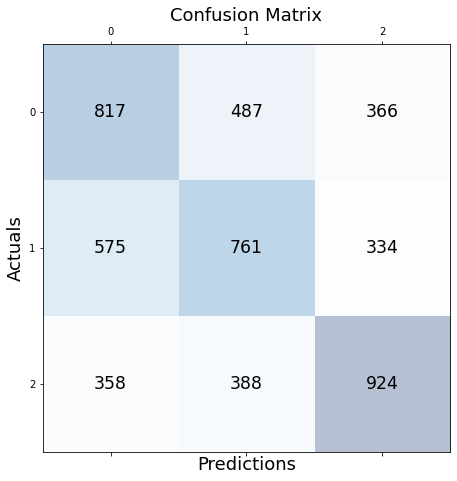

In [24]:
# Print the confusion matrix using Matplotlib
#
import matplotlib.pyplot as plt
conf_matrix = confusion_matrix(test_label_original[0],predicted_label[0])
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [79]:
demo = generate_dataset('demo_LR.json')

In [80]:
print(demo['premise'][0],',',demo['hypothesis'][0])

3 महिलाएं घर में खाना बना रही हैं  , घर में 3 आदमी हैं


In [81]:
logistic_regression_test(demo)

neutral



In [12]:
train_data.shape

(392702, 3)

In [13]:
X = train_data[0:151300]

In [15]:
X.shape

(151300, 3)

In [20]:
test_feature, test_label = TFIDF_features(train_data, "test")

In [21]:
test_feature.shape

(392702, 27776)